## Spark SQL을 이용한 Trip Data 분석

In [2]:
# [+] SparkSession 임포트
import findspark
findspark.init()

from pyspark.sql import SparkSession

In [3]:
# [+] SparkSession 객체 생성 및 설정
spark = SparkSession.builder.master('local').appName('trip-data-sql').getOrCreate()

### 데이터셋 준비
1. TLC Trip Record, High Volume For-Hire Vehicle Trip Records (2020년 3월)
2. Taxi Zone Maps and Lookup Tables

In [4]:
# 파일 및 경로
trip_data = "fhvhv_tripdata_2020-03_short.csv"
zone_data = "taxi_zone_lookup_coordinates_v2.csv"
path = "./data/"

### Trip Data
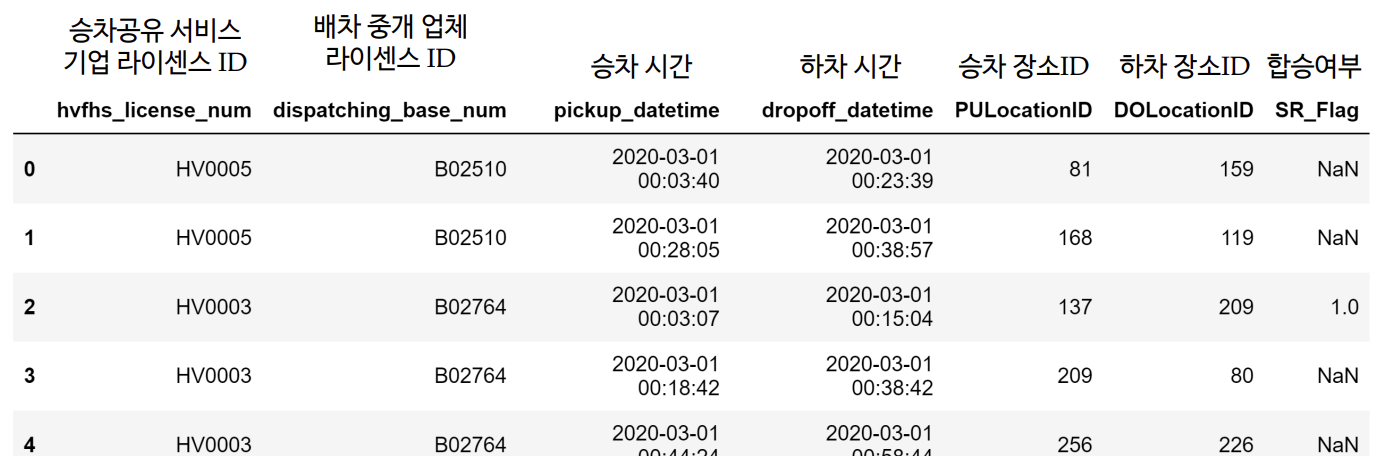

In [5]:
# [+] 스키마 정의에 필요한 클래스 임포트
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType

#### Trip Data 스키마 정의
| 필드  | 데이터 타입   | Nullable   |
|--------|--------|--------|
| hvfhs_license_num | String | False |
| dispatching_base_num | String | True |
| pickup_datetime | Timestamp | False |
| dropoff_datetime | Timestamp | False |
| PULocationID | Integer | True |
| DOLocationID | Integer | True |
| SR_Flag | String | True |

In [6]:
# [+] Trip Data 스키마 정의
tripSchema = StructType([
    StructField('hvfhs_license_num', StringType(), False),
    StructField('dispatching_base_num', StringType(), True),
    StructField('pickup_datetime', TimestampType(), False),
    StructField('dropoff_datetime', TimestampType(), False),
    StructField('PULocationID', IntegerType(), True),
    StructField('DOLocationID', IntegerType(), True),
    StructField('SR_Flag', StringType(), True)
])

In [7]:
# 데이터프레임 생성(trip_data, zone_data)
df_trip = spark.read.csv(path + trip_data, tripSchema, header = True)
df_zone = spark.read.csv(path + zone_data, inferSchema=True, header = True) # 스키마 정의안했음.알아서 정의해줘(inferSchema)

In [8]:
# [+] df_trip 내용 출력
df_trip.show()

+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+
|hvfhs_license_num|dispatching_base_num|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|SR_Flag|
+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+
|           HV0005|              B02510|2020-03-01 00:03:40|2020-03-01 00:23:39|          81|         159|   null|
|           HV0005|              B02510|2020-03-01 00:28:05|2020-03-01 00:38:57|         168|         119|   null|
|           HV0003|              B02764|2020-03-01 00:03:07|2020-03-01 00:15:04|         137|         209|      1|
|           HV0003|              B02764|2020-03-01 00:18:42|2020-03-01 00:38:42|         209|          80|   null|
|           HV0003|              B02764|2020-03-01 00:44:24|2020-03-01 00:58:44|         256|         226|   null|
|           HV0003|              B02682|2020-03-01 00:17:23|2020-03-01 00:39:35|

In [9]:
# [+] df_zone 내용 출력
df_zone.show()

+----------+-------------+--------------------+------------+-----------+------------+
|LocationID|      Borough|                Zone|service_zone|   latitude|   longitude|
+----------+-------------+--------------------+------------+-----------+------------+
|         1|          EWR|      Newark Airport|         EWR|40.69287997|-74.18544993|
|         2|       Queens|         Jamaica Bay|   Boro Zone|    40.6057|    -73.8713|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|40.86521003| -73.8435548|
|         4|    Manhattan|       Alphabet City| Yellow Zone|   40.72599|   -73.98057|
|         5|Staten Island|       Arden Heights|   Boro Zone|    40.5564|    -74.1735|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|    40.5927|      -74.07|
|         7|       Queens|             Astoria|   Boro Zone|    40.7644|    -73.9235|
|         8|       Queens|        Astoria Park|   Boro Zone|    40.7785|    -73.9228|
|         9|       Queens|          Auburndale|   Boro

#### Temporary View 생성
| 데이터프레임  | 뷰 이름   |
|--------|--------|
| df_trip | trip_data |
| df_zone | zone_data |

In [10]:
# [+] Temporary view 생성
df_trip.createOrReplaceTempView('trip_data')
df_zone.createOrReplaceTempView('zone_data')

In [11]:
# SQL 테스트
df_trip.select('*').show()
spark.sql("SELECT * FROM zone_data").show()

+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+
|hvfhs_license_num|dispatching_base_num|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|SR_Flag|
+-----------------+--------------------+-------------------+-------------------+------------+------------+-------+
|           HV0005|              B02510|2020-03-01 00:03:40|2020-03-01 00:23:39|          81|         159|   null|
|           HV0005|              B02510|2020-03-01 00:28:05|2020-03-01 00:38:57|         168|         119|   null|
|           HV0003|              B02764|2020-03-01 00:03:07|2020-03-01 00:15:04|         137|         209|      1|
|           HV0003|              B02764|2020-03-01 00:18:42|2020-03-01 00:38:42|         209|          80|   null|
|           HV0003|              B02764|2020-03-01 00:44:24|2020-03-01 00:58:44|         256|         226|   null|
|           HV0003|              B02682|2020-03-01 00:17:23|2020-03-01 00:39:35|

In [12]:
# AS 키워드: 필드를 다른 이름으로 사용
spark.sql("SELECT PULocationID AS departure_area, \
            DOLocationID AS arrival_area \
            FROM trip_data").show()

+--------------+------------+
|departure_area|arrival_area|
+--------------+------------+
|            81|         159|
|           168|         119|
|           137|         209|
|           209|          80|
|           256|         226|
|            79|         263|
|            61|          29|
|           150|         150|
|           150|         210|
|            60|         167|
|            47|         213|
|           213|         235|
|           243|         153|
|           127|          18|
|            18|         169|
|            94|         169|
|           211|         158|
|           246|         107|
|           234|           9|
|           139|          10|
+--------------+------------+
only showing top 20 rows



#### cast(): 데이터 타입 변환 함수
+ 예: ```cast(pickup_datetime AS Long)```
+ ```AS``` 키워드: 필드 데이터 유형 지정
+ 변환된 Long 값: 1970년 1월 1일 00:00:00 UTC 이후 누적된 시간(초 단위)

In [12]:
# cast(): 데이터 타입 변환
spark.sql("SELECT cast(pickup_datetime AS LONG) \
            FROM trip_data").show()

+---------------+
|pickup_datetime|
+---------------+
|     1582988620|
|     1582990085|
|     1582988587|
|     1582989522|
|     1582991064|
|     1582989443|
|     1582988478|
|     1582991007|
|     1582991543|
|     1582989589|
|     1582990174|
|     1582990904|
|     1582989086|
|     1582990085|
|     1582991068|
|     1582991810|
|     1582991774|
|     1582989255|
|     1582990298|
|     1582989991|
+---------------+
only showing top 20 rows



In [15]:
# [+] 승차시간 - 하차시간 (sec.)
spark.sql("SELECT cast(dropoff_datetime AS LONG) - cast(pickup_datetime AS LONG) \
            FROM trip_data").show()

+--------------------------------------------------------------------+
|(CAST(dropoff_datetime AS BIGINT) - CAST(pickup_datetime AS BIGINT))|
+--------------------------------------------------------------------+
|                                                                1199|
|                                                                 652|
|                                                                 717|
|                                                                1200|
|                                                                 860|
|                                                                1332|
|                                                                2254|
|                                                                 240|
|                                                                 472|
|                                                                 231|
|                                                                 585|
|     

In [13]:
# [+] 이용시간(trip_duration) = 승차시간 - 하차시간 (in minutes)
spark.sql("SELECT (cast(dropoff_datetime AS LONG) - cast(pickup_datetime AS LONG))/60 \
            AS trip_duration \
            FROM trip_data").show()

+------------------+
|     trip_duration|
+------------------+
|19.983333333333334|
|10.866666666666667|
|             11.95|
|              20.0|
|14.333333333333334|
|              22.2|
| 37.56666666666667|
|               4.0|
| 7.866666666666666|
|              3.85|
|              9.75|
|16.483333333333334|
|13.333333333333334|
|             10.85|
| 7.683333333333334|
|               2.6|
|               7.4|
|12.533333333333333|
|26.483333333333334|
|              11.6|
+------------------+
only showing top 20 rows



In [14]:
# [+] LIMIT 키워드
spark.sql("SELECT * FROM zone_data LIMIT 5").show()     # ex) 데이터 정렬하고 상위 10개 보여줘. 이런 거 할 떄 주로 사용

+----------+-------------+--------------------+------------+-----------+------------+
|LocationID|      Borough|                Zone|service_zone|   latitude|   longitude|
+----------+-------------+--------------------+------------+-----------+------------+
|         1|          EWR|      Newark Airport|         EWR|40.69287997|-74.18544993|
|         2|       Queens|         Jamaica Bay|   Boro Zone|    40.6057|    -73.8713|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|40.86521003| -73.8435548|
|         4|    Manhattan|       Alphabet City| Yellow Zone|   40.72599|   -73.98057|
|         5|Staten Island|       Arden Heights|   Boro Zone|    40.5564|    -74.1735|
+----------+-------------+--------------------+------------+-----------+------------+



In [16]:
# GROUP BY 키워드
# count(*): 그룹별 행 개수 집계
# 승차공유 서비스 기업 별 총 승차 횟수 계산
spark.sql("SELECT hvfhs_license_num AS company_id, count(*) AS trips \
            FROM trip_data \
            GROUP BY company_id").show()

+----------+-------+
|company_id|  trips|
+----------+-------+
|    HV0004| 147216|
|    HV0005|1176143|
|    HV0003|3537637|
+----------+-------+



In [18]:
# Manhattan에서 출발한 총 승차 횟수 계산
spark.sql("SELECT borough, count(*) AS trips FROM \
            (SELECT zone_data.Borough AS borough \
             FROM trip_data \
             JOIN zone_data \
             ON trip_data.PULocationID = zone_data.LocationID) \
             GROUP BY borough").show()

+-------------+-------+
|      borough|  trips|
+-------------+-------+
|       Queens| 858254|
|          EWR|    142|
|     Brooklyn|1280051|
|Staten Island|  61935|
|    Manhattan|2028145|
|        Bronx| 632198|
+-------------+-------+



In [40]:
# 승차 장소, 이용시간(trip_duration) 계산 후 데이터프레임에 저장
df_duration = spark.sql(
    "SELECT PULocationID AS departure_area, \
    ((cast(dropoff_datetime AS Long) - cast(pickup_datetime AS Long)) / 60) \
    AS trip_duration \
    FROM trip_data ")
df_duration.show()

+--------------+------------------+
|departure_area|     trip_duration|
+--------------+------------------+
|            81|19.983333333333334|
|           168|10.866666666666667|
|           137|             11.95|
|           209|              20.0|
|           256|14.333333333333334|
|            79|              22.2|
|            61| 37.56666666666667|
|           150|               4.0|
|           150| 7.866666666666666|
|            60|              3.85|
|            47|              9.75|
|           213|16.483333333333334|
|           243|13.333333333333334|
|           127|             10.85|
|            18| 7.683333333333334|
|            94|               2.6|
|           211|               7.4|
|           246|12.533333333333333|
|           234|26.483333333333334|
|           139|              11.6|
+--------------+------------------+
only showing top 20 rows



In [42]:
# [+] df_duration 의 Temporary view 생성
df_duration.createOrReplaceTempView('duration_data')

In [43]:
# [+] 승차 장소 별 평균 이용시간 계산
spark.sql(
    "SELECT departure_area, mean(trip_duration) \
    AS trip_duration_avg \
    FROM duration_data \
    GROUP BY departure_area \
    ORDER BY trip_duration_avg DESC").show()

+--------------+------------------+
|departure_area| trip_duration_avg|
+--------------+------------------+
|             1| 44.56326291079813|
|           110| 39.65555555555556|
|           132| 38.71674576170034|
|           138| 33.06151102630442|
|            88|24.265348782357492|
|           202| 24.10470637234486|
|             2|23.897916666666667|
|           261| 23.84326740903992|
|            12|  23.0576855123675|
|            87| 22.86435191518471|
|           100| 22.84655371561205|
|           105|22.616666666666667|
|           230|22.454540890259782|
|           161|22.450788385043985|
|           186|22.072682432056936|
|           199|22.066666666666666|
|           163|21.982067918049243|
|           162|21.720410215504728|
|            13|21.382689958303427|
|           194| 21.35459927140255|
+--------------+------------------+
only showing top 20 rows

